# DS-SF-36 | Unit Project | 3 | Machine Learning Modeling and Executive Summary | Starter Code

In this project, you will perform a logistic regression on the admissions data we've been working with in Unit Project 1 and 2.  You will summarize and present your findings and the methods you used.

In [58]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.notebook_repr_html', True)

import statsmodels.formula.api as smf

from sklearn import linear_model

In [59]:
df = pd.read_csv(os.path.join('..', '..', 'dataset', 'dataset-ucla-admissions.csv'))
df.dropna(inplace = True)

df

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0
...,...,...,...,...
395,0,620.0,4.00,2.0
396,0,560.0,3.04,3.0
397,0,460.0,2.63,2.0
398,0,700.0,3.65,2.0


## Part A.  Frequency Table

> ### Question 1.  Create a frequency table for `prestige` and whether an applicant was admitted.

In [60]:
pd.crosstab(df.admit, df.prestige, dropna = False)

prestige,1.0,2.0,3.0,4.0
admit,,,,
0,28,95,93,55
1,33,53,28,12


## Part B.  Feature Engineering

> ### Question 2.  Create a one-hot encoding for `prestige`.

In [61]:
df.prestige.value_counts(dropna = False).sort_index()

1.0     61
2.0    148
3.0    121
4.0     67
Name: prestige, dtype: int64

In [62]:
prestige_df = pd.get_dummies(df.prestige, prefix = 'prestige')

In [63]:
prestige_df

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
395,0,1,0,0
396,0,0,1,0
397,0,1,0,0
398,0,1,0,0


In [64]:
prestige_df.rename(columns = {'prestige_1.0': 'prestige_1',
    'prestige_2.0': 'prestige_2',
    'prestige_3.0': 'prestige_3',
    'prestige_4.0': 'prestige_4'}, inplace = True)

In [65]:
prestige_df

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
395,0,1,0,0
396,0,0,1,0
397,0,1,0,0
398,0,1,0,0


In [66]:
df = df.join([prestige_df])

In [67]:
df.columns

Index([u'admit', u'gre', u'gpa', u'prestige', u'prestige_1', u'prestige_2',
       u'prestige_3', u'prestige_4'],
      dtype='object')

> ### Question 3.  How many of these binary variables do we need for modeling?

Answer: For modeling you would need 2 binary variables since machine learning is either finding an optimal point or finding a point in a regression.

> ### Question 4.  Why are we doing this?

Answer: We are doing this because categories can't be used in classification and regression algorithms.

> ### Question 5.  Add all these binary variables in the dataset and remove the now redundant `prestige` feature.

In [68]:
df.sum()

admit            126.00
gre           233380.00
gpa             1346.72
prestige         988.00
prestige_1        61.00
prestige_2       148.00
prestige_3       121.00
prestige_4        67.00
dtype: float64

In [69]:
del df['prestige']

## Part C.  Hand calculating odds ratios

Let's develop our intuition about expected outcomes by hand calculating odds ratios.

> ### Question 6.  Create a frequency table for `prestige = 1` and whether an applicant was admitted.

In [70]:
pd.crosstab(df.admit, df['prestige_1'], dropna = False)

prestige_1,0,1
admit,,
0,243,28
1,93,33


> ### Question 7.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the most prestigious undergraduate schools.

In [71]:
result = 126 % 397

print(result)

126


> ### Question 8.  Now calculate the odds of admission for undergraduates who did not attend a #1 ranked college.

In [75]:
pd.crosstab(df.admit, [df['prestige_1'], df['prestige_2'], df['prestige_3'], df['prestige_4']], dropna = False)

prestige_1  0                ...  1            
prestige_2  0              1 ...  0  1         
prestige_3  0       1      0 ...  1  0     1   
prestige_4  0   1   0  1   0 ...  1  0  1  0  1
admit                        ...               
0           0  55  93  0  95 ...  0  0  0  0  0
1           0  12  28  0  53 ...  0  0  0  0  0

[2 rows x 16 columns]

In [78]:
#The odds of admission for undergraduates who did not attend a #1 ranked college.
93 % 336

93

> ### Question 9.  Finally, what's the odds ratio?

> ### Question 10.  Write this finding in a sentence.

The odds of admission when applying from schools that are not ranked #1 are lower than applying from ones that are.

> ### Question 11.  Use the frequency table above to calculate the odds of being admitted to graduate school for applicants that attended the least prestigious undergraduate schools.  Then calculate their odds ratio of being admitted to UCLA.  Finally, write this finding in a sentence.

In [ ]:
#The odds of admission for undergraduates who did not attend a #1 ranked college.
93 % 336

In [ ]:
#Odds ratio of being admitted to UCLA

Answer: TODO

## Part D. Analysis using `statsmodels`

> ### Question 12.  Fit a logistic regression model predicting admission into UCLA using `gre`, `gpa`, and the `prestige` of the undergraduate schools.  Use the highest prestige undergraduate schools as your reference point.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
from IPython.display import Image
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification;

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import scipy.stats as stats

/Users/raymonddelacruz/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


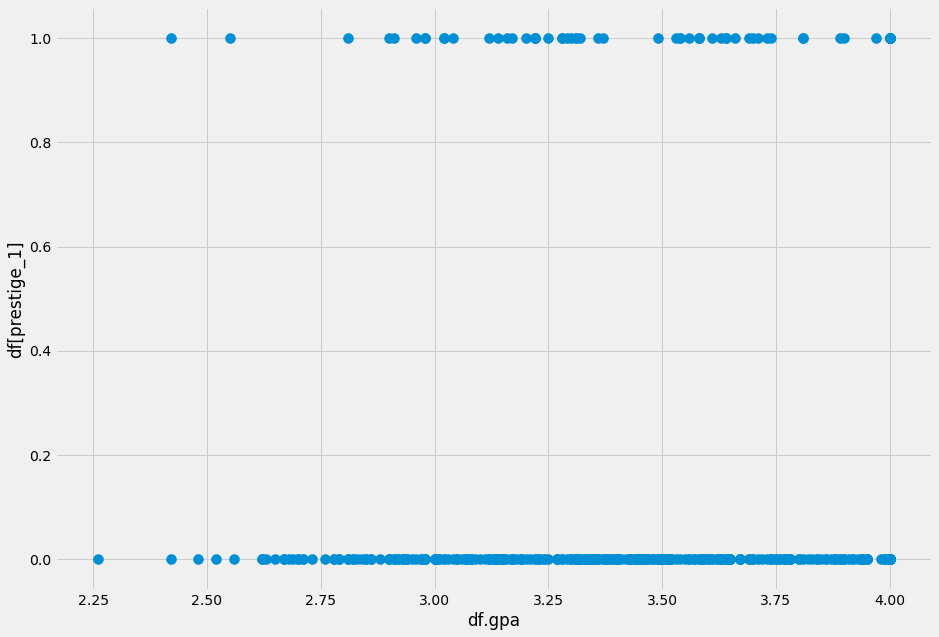

In [98]:
plt.figure(figsize=(14,10))
plt.scatter(df.gpa, df['prestige_1'], s=100)
plt.xlabel("df.gpa",)
plt.ylabel("df[prestige_1]");

In [99]:
X = df[["prestige_1"]]
y = df.gpa

linreg = LinearRegression()

linreg.fit(X, y)

pred = linreg.predict(X);

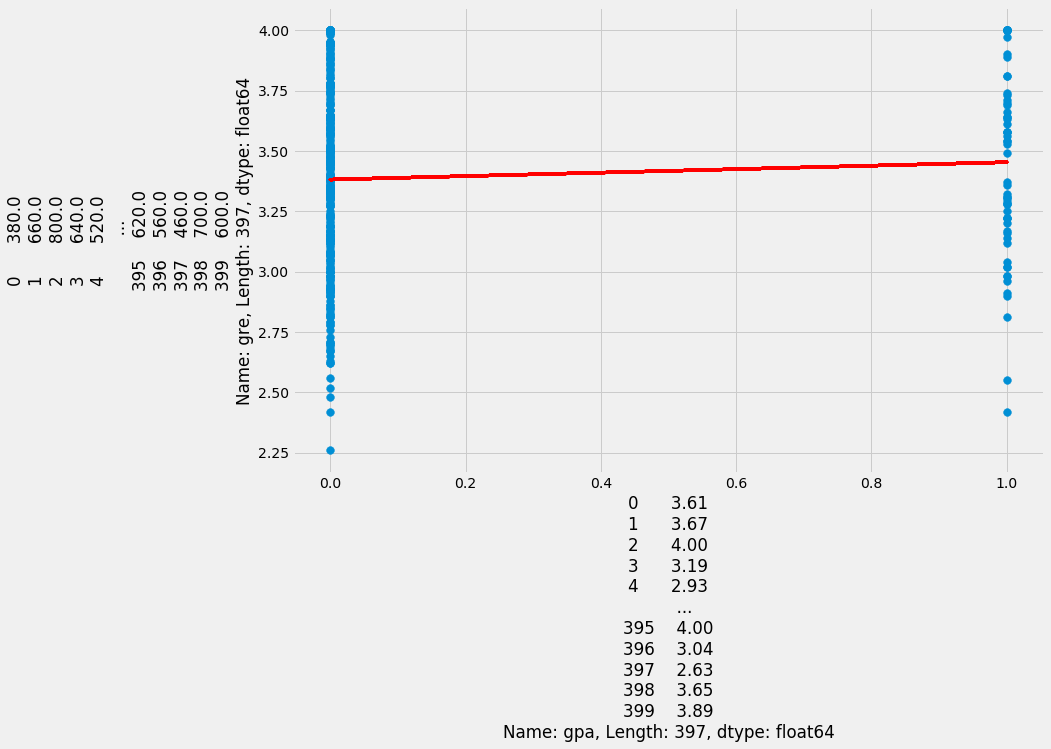

In [104]:
plt.figure(figsize=(12,8))
plt.xlabel(df.gpa)
plt.ylabel(df.gre)
plt.scatter(X,y, s=60)
plt.plot(X, pred, c="r", linewidth=3);

> ### Question 13.  Print the model's summary results.

In [109]:
def Xy(df):
    X = df.admit

    y = df['prestige_1']

    return X, y

X, y = Xy(df)

model = smf.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             prestige_1   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     65.37
Date:                Sun, 20 Aug 2017   Prob (F-statistic):           7.63e-15
Time:                        23:13:17   Log-Likelihood:                -161.19
No. Observations:                 397   AIC:                             324.4
Df Residuals:                     396   BIC:                             328.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
admit          0.2619      0.032      8.085      0.000       0.198       0.326
==============================================================================
Omnibus:                      110.514   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.196
Skew:                           1.605   Prob(JB):                     1.68e-45
Kurtosis:                       4.472   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> ### Question 14.  What are the odds ratios of the different features and their 95% confidence intervals?

In [111]:
table['odds'] = table.probability/(1 - table.probability)
table

NameError: name 'table' is not defined

> ### Question 15.  Interpret the odds ratio for `prestige = 2`.

Answer: TODO

> ### Question 16.  Interpret the odds ratio of `gpa`.

Answer: TODO

> ### Question 17.  Assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [ ]:
# TODO

Answer: TODO

## Part E. Moving the model from `statsmodels` to `sklearn`

> ### Question 18.  Let's assume we are satisfied with our model.  Remodel it (same features) using `sklearn`.  When creating the logistic regression model with `LogisticRegression(C = 10 ** 2)`.

In [ ]:
# TODO

> ### Question 19.  What are the odds ratios for the different variables and how do they compare with the odds ratios calculated with `statsmodels`?

In [ ]:
# TODO

Answer: TODO

> ### Question 20.  Again, assuming a student with a GRE of 800 and a GPA of 4.  What is his/her probability of admission  if he/she come from a tier-1, tier-2, tier-3, or tier-4 undergraduate school?

In [ ]:
# TODO

Answer: TODO

## Part F.  Executive Summary

> ## Question 21.  Introduction
>
> Write a problem statement for this project.

When applying to graduate programs, there are different factors that are considered. For future applicants, this data can show which areas to focus on.

> ## Question 22.  Dataset
>
> Write up a description of your data and any cleaning that was completed.

Overall the data was clean. The main thing that needed to be updated was prestige when writing a frequency table.

> ## Question 23.  Demo
>
> Provide a table that explains the data by admission status.

Answer: TODO

> ## Question 24.  Methods
>
> Write up the methods used in your analysis.

Answer: TODO

> ## Question 25.  Results
>
> Write up your results.

Answer: TODO

> ## Question 26.  Visuals
>
> Provide a table or visualization of these results.

Answer: TODO

> ## Question 27.  Discussion
>
> Write up your discussion and future steps.

Answer: TODO